Read in prevalence filtered( %1) otu table

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas import DataFrame as df
import numpy as np
import csv
from itertools import combinations
from sklearn.model_selection import train_test_split
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import pickle

from sklearn.metrics import pairwise_distances

In [1]:
def getData(qual_vec_type = "500"):
    otu = pd.read_csv("data/silva/freshwater/otu_filtered_freshwater.csv", sep = "\t", index_col=0)
    print(otu.shape)
    otu.head()
    #Delete samples that have no taxa
    otu = otu.loc[:, otu.sum(axis=0) != 0]
    
    #Read quality vector data
    if qual_vec_type == "100":
        qual_vecs = pd.read_csv("embeddings/silva/glove_emb_freshwater_100.txt", sep = " ", index_col = 0, header=None)
    if qual_vec_type == "500":
        qual_vecs = pd.read_csv("embeddings/silva/glove_emb_freshwater_2perc_500.txt", sep = " ", index_col = 0, header=None)
    print(qual_vecs.shape)
    qual_vecs.head()
    
    #Match taxa present in quality vectors with those in otu table
    bools_drop = [i not in qual_vecs.index.values for i in otu.index.values]
    drop = otu.index.values[bools_drop]
    otu_drop = otu.drop(drop, axis = 0)
    print("OTU DROP SHAPE: " + str(otu_drop.shape))
    
    qual_vecs = qual_vecs.drop("<unk>", axis = 0)
    qual_vecs_sort = qual_vecs.reindex(sorted(qual_vecs.index.values), axis = 0)
    otu = otu_drop.reindex(sorted(otu_drop.index.values), axis = 0) #Organize otu rows to match taxa in qual_vecs

    ntaxa = qual_vecs.shape[0]
    print(ntaxa)
    bools_correct = [qual_vecs_sort.index.values[i] == otu.index.values[i] for i in range(ntaxa)]

    if (np.sum(bools_correct) == qual_vecs_sort.shape[0]) and (np.sum(bools_correct) == otu.shape[0]):
        print("Safe to continue")
    else:
        print("STOP! Something is wrong.")
        
        
    #Read mapping data
    mapping = pd.read_csv("data/emp_qiime_mapping_release1.tsv.csv", sep = ",", index_col=0, encoding='latin1')
    print("Mapping has shape: " + str(mapping.shape))

    map_filt = mapping.loc[mapping['empo_3'] == "Water (non-saline)"]
    print("After selecting for biome, mapping has shape " + str(map_filt.shape))

    bools = [i in otu.columns.values for i in map_filt.index.values]
    map_filt = map_filt.loc[bools]
    print("After selecting just the samples present in the otu table: " + str(map_filt.shape))

    otu_sort = otu.reindex(sorted(otu.columns.values), axis = 1)
    map_filt_sort = map_filt.reindex(sorted(map_filt.index.values), axis = 0)
    nsamples = map_filt.shape[0]
    bools_correct = [map_filt_sort.index.values[i] == otu_sort.columns.values[i] for i in range(nsamples)]
    print("After rearranging, we have " + str(np.sum(bools_correct)) + " matching samples")
    if (np.sum(bools_correct) == map_filt_sort.shape[0]) and (np.sum(bools_correct) == otu_sort.shape[1]):
        print("Safe to continue")
    else:
        print("STOP! Something is wrong.")
        
        
    #temperature
    #phosphate
    #ammonia
    #map_filt_sort.loc[map_filt_sort['temperature_deg_c']]
    bools =  ~map_filt_sort['temperature_deg_c'].isnull() 
    map_temp = map_filt_sort.loc[~map_filt_sort['temperature_deg_c'].isnull()]
    otu_temp = otu_sort.loc[:, bools]
    bools_correct = [map_temp.index.values[i] == otu_temp.columns.values[i] for i in range(map_temp.shape[0])]
    print("We will be working with " + str(np.sum(bools_correct)) + " samples that have temperature information")
    
    
    #One final check after all transformations
    qual_vecs = qual_vecs_sort
    bools_correct = [qual_vecs.index.values[i] == otu_temp.index.values[i] for i in range(ntaxa)]
    if (np.sum(bools_correct) == qual_vecs_sort.shape[0]) and (np.sum(bools_correct) == otu.shape[0]):
        print("Safe to continue")
    else:
        print("STOP! Something is wrong.")
        
    pd_qual_vecs = pd.DataFrame(qual_vecs)
    otu = otu_temp.T
    
    otu_train = otu.loc[map_temp.study_id != 1883, :]
    otu_test = otu.loc[map_temp.study_id == 1883, :]
    map_train = map_temp.loc[map_temp.study_id != 1883, :]
    map_test = map_temp.loc[map_temp.study_id == 1883, :]
    #map_temp = map_temp.loc[map_temp.study_id != 1041, :]
    return(otu_train, otu_test, pd_qual_vecs, map_train, map_temp)

Put a prevalence filter on taxa

In [10]:
#otu.shape
#num_samples_present = np.count_nonzero(np.matrix(otu), axis = 1)
#print(len(num_samples_present))
#print(num_samples_present)
#plt.hist(num_samples_present, range = (0, 300))

#I can't come up with a lower threshold from the histograms, but it will definitely be relevant that we have some taxa that are ALWAYS present.
#This is essentially a participle like "a" or "the" and there are ways to handle this, but I don't know what they are

Read in mapping file, sort, and filter so dimensions and orders match

In [4]:
otu_train, otu_test, qual_vecs_500, map_train, map_test = getData(qual_vec_type = "500")
#otu_train, otu_test, qual_vecs_100, mapping = getData(qual_vec_type = "100")

(18567, 5817)
(11133, 500)
OTU DROP SHAPE: (11132, 5790)
11132
Safe to continue
Mapping has shape: (27751, 75)
After selecting for biome, mapping has shape (5940, 75)
After selecting just the samples present in the otu table: (5790, 75)
After rearranging, we have 5790 matching samples
Safe to continue
We will be working with 4490 samples that have temperature information
Safe to continue


In [12]:
qual_vecs_500.shape

(11132, 500)

In [14]:
#filter
#Sample must have more than 5000 reads
otu_train_filt = otu_train.loc[otu_train.sum(axis=1) > 3000, :]
otu_test_filt = otu_test.loc[otu_test.sum(axis=1) > 3000, :]

#Discard samples that have no taxa
otu_train_filt = otu_train_filt.loc[otu_train_filt.sum(axis = 1) > 0, :]
otu_test_filt = otu_test_filt.loc[otu_test_filt.sum(axis = 1) > 0, :]

#Discard taxa that have no samples
taxa_keep_train = np.array(otu_train_filt.sum(axis = 0) > 0)
taxa_keep_test = np.array(otu_test_filt.sum(axis = 0) > 0)
taxa_keep = [taxa_keep_train[i] & taxa_keep_test[i] for i in range(otu_train_filt.shape[1])]
otu_train_filt = otu_train_filt.loc[:, taxa_keep]
otu_test_filt = otu_test_filt.loc[:, taxa_keep]

map_train = map_train.loc[otu_train_filt.index.values]
map_test = map_test.loc[otu_test_filt.index.values]

print(otu_train_filt.shape)
print(map_train.shape)
print(otu_test_filt.shape)
print(map_test.shape)



(2490, 10302)
(2490, 75)
(1448, 10302)
(1448, 75)


In [23]:

f = open("data/silva/otu_train.obj", "wb")
pickle.dump(otu_train_filt, f)
f.close()

f = open("data/silva/otu_test.obj", "wb")
pickle.dump(otu_test_filt, f)
f.close()

f = open("data/silva/qual_vecs_500.obj", "wb")
pickle.dump(qual_vecs_500, f)
f.close()

f = open("data/silva/map_train.obj", "wb")
pickle.dump(map_train, f)
f.close()

f = open("data/silva/map_test.obj", "wb")
pickle.dump(map_test, f)
f.close()

#otu_train_filt.to_csv("data/silva/otu_train.csv", header = True, index = True, index_label = "Sample")
#otu_test_filt.to_csv("data/silva/otu_test.csv", header = True, index = True, index_label = "Sample")


f = open("data/silva/otu_train.obj", "wb")
otu_train = pickle.load(f)
f.close()

f = open("data/silva/otu_test.obj", "wb")
otu_test = pickle.load(f)
f.close()

f = open("data/silva/qual_vecs.obj", "wb")
pickle.dump(qual_vecs, f)
f.close()

f = open("data/silva/map_train.obj", "wb")
pickle.dump(map_train, f)
f.close()

f = open("data/silva/map_test.obj", "wb")
pickle.dump(map_test, f)
f.close()

In [17]:
def normalize(otu):
    #Normalize
    sample_sums = otu.sum(axis=1)
    otu_norm = otu.div(sample_sums, axis=0)
    return(otu_norm)

def biofilter(otu):
    #Filter for useful taxa
    file = open('feature_selection/taxa_lowphy_highcos.obj', 'rb')
    taxa_lowphy_highcos = pickle.load(file)
    file.close()
    otu_use = otu[list(taxa_lowphy_highcos)]
    return(otu_use)

def embed(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    df = pd.DataFrame(np.dot(otu, qual_vecs_use), index = otu.index.values)
    return(df)


otu_norm = normalize(otu_train)
otu_biofilter_norm = biofilter(otu_norm) #Biofilter using new embeddings
otu_biofilter_nonorm = biofilter(otu_train)

#otu_emb_norm_100 = embed(otu_norm, qual_vecs_100)
otu_emb_norm_500 = embed(otu_norm, qual_vecs_500)




In [ ]:
print(otu_norm.shape)
print(otu_biofilter_norm.shape)

In [ ]:
np.sum([np.isnan(i) for i in otu_use.sum(axis=1)])
np.sum([i == 0 for i in sample_sums])

MACHINE LEARNING PORTION

In [ ]:
def plotLineOfBestFit(xi, y, title = ""):
    print(np.max(y))
    cut = np.where(xi > 30)
    cut2 = np.where(xi < -30)
    

    y = y.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(xi,y)
    line = slope*xi+intercept
    plt.plot(xi,y,'o', xi, line)
    
    #perfect line
    #plt.plot(
    
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")
    plt.title(title)
    plt.ylim((0,12))
    print("Slope: " + str(slope))
    print("R value: " + str(r_value))

In [ ]:
def testModel(X_train, y_train, X_test, y_test, model, title):
    if model == "linreg":
        m = linear_model.LinearRegression()
    if model == "svm":
        m = svm.SVR(gamma = "scale")
    if model == "rf":
        m = RandomForestRegressor(max_depth= 12, random_state=0, n_estimators=140)
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    
    plotLineOfBestFit(preds, y_test, title)

    error = np.mean([np.absolute(y_test[i] - preds[i]) for i in range(len(preds))])
    mse = np.mean([np.square(y_test[i] - preds[i]) for i in range(len(preds))])
    print("Linear Error" + str(error) + "   MSE: " + str(mse))
    return(error, mse)
    #plotLineOfBestFit(y_test, preds, title = title)
#testModel(X_train, y_train, X_test, y_test, model = "linreg", title = "")

In [ ]:
y = mapping['temperature_deg_c']
indicies = np.arange(otu_norm.shape[0])


In [ ]:
test_size = 0.25
X_train, X_test, y_train, y_test, inx_train, inx_test = train_test_split(otu_use, y, indicies, test_size = test_size, random_state = 0)

X_train_emb, X_test_emb, y_train, y_test = train_test_split(otu_emb_100, y, test_size = test_size, random_state = 0)
#Splits are the same b/c of same random state

pca = PCA(n_components= 100)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

map_train = map_temp.iloc[inx_train, :]

In [15]:
def plotPCA(table):
    
    pca = PCA(n_components= 5)
    pca.fit(table)
    table_pca = pca.transform(table)
    table_pca = table_pca / np.max(table_pca)
    df = pd.DataFrame(table_pca, index = table.index.values)
    #df.add(mapping.temperature_deg_c)
    plt.figure(figsize=(10,5))
    sample_sums_table = table.sum(axis = 1)
    
    plt.scatter(df.iloc[:,0], df.iloc[:,1], c = sample_sums_table, cmap='viridis')
    plt.xlabel(pca.explained_variance_ratio_[0])
    plt.ylabel(pca.explained_variance_ratio_[1])
    print(pca.explained_variance_ratio_[0:2])
    return(df)
    
#otu_norm_pca = plotPCA(otu_norm)

[0.59542094 0.20251532]


,0,1,2,3,4
1041.M028.10,0.005614,0.088538,-0.002897,0.007779,-0.005077
1041.M028.100,0.007652,0.097537,-0.005248,0.007669,-0.001701
1041.M028.10m.off.bottom,-0.000985,0.067195,-0.003383,0.005245,-0.003367
1041.M028.20,0.001999,0.078694,-0.004562,0.006317,-0.002067
1041.M028.2m.off.bottom,0.010187,0.101639,-0.002467,0.008061,-0.005065
1041.M028.5,0.012740,0.105691,-0.003062,0.010055,-0.005209
1041.M028.50,0.006607,0.091629,-0.003169,0.007956,-0.005043
1041.M041.10,-0.011852,0.044584,-0.003524,0.002815,-0.003300
1041.M041.100,-0.013548,0.039153,-0.002678,0.001682,-0.003910
1041.M041.10m.off.bottom,-0.011014,0.049636,-0.001080,0.001463,-0.005439


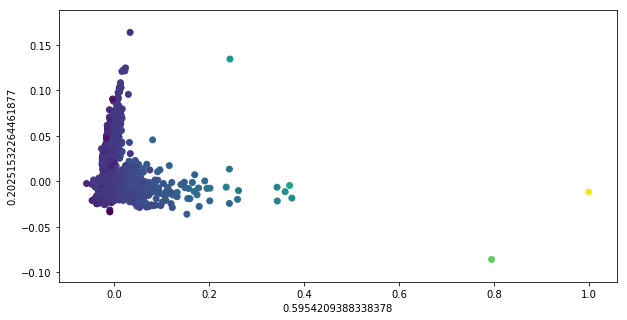

In [18]:
plotPCA(embed(otu_train, qual_vecs_500))

In [ ]:
otu_emb_norm_100_pca = plotPCA(otu_emb_norm_100)

[0.40798137 0.2280035 ]


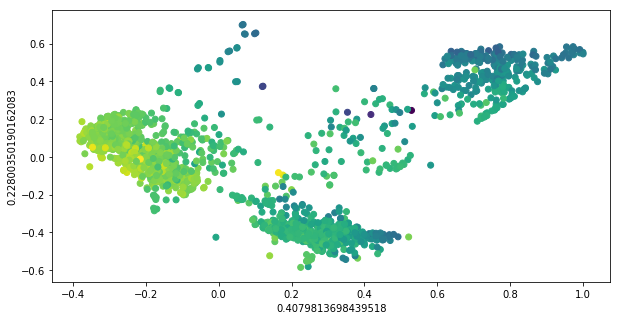

In [19]:
otu_emb_norm_500_pca = plotPCA(otu_emb_norm_500)

We're hoping to decrease the study bias, unless interesting covariates are also biased by study. 

In a strongly clustered sample, we should see high between and low within group distances, meaning the clusterin ratio (Between / Within) would be very high

In a very dispersed sample, we should see low between and high within group distances, meaning the clustering ratio will be low. 


In [520]:
def getWithinBetweenDists(table):
    table = table / np.max(table)
    dists = pairwise_distances(table, metric = "braycurtis")
    dists = pd.DataFrame(dists, index = table.index.values, columns = table.index.values)
    withinGroupDists = list()
    betweenGroupDists = list()
    for study_id in set(mapping.study_id):
        keep = mapping.loc[dists.index.values, "study_id"] == study_id
        withinGroup = dists.loc[keep, keep]
        betweenGroup = dists.loc[keep, ~keep]
        withinGroupDists.append(np.mean(withinGroup.values.tolist()))
        betweenGroupDists.append(np.mean(betweenGroup.values.tolist()))
    print(withinGroupDists)
    print(betweenGroupDists)
    return(np.array(betweenGroupDists) / np.array(withinGroupDists))

otu_emb_norm_500_pca_groupdists = getWithinBetweenDists(otu_emb_norm_500_pca)
otu_norm_pca_groupdists = getWithinBetweenDists(otu_norm_pca)

otu_emb_norm_500_groupdists = getWithinBetweenDists(otu_emb_norm_500)
#otu_norm_groupdists = getWithinBetweenDists(otu_norm)

[0.4332469705667368, 0.07030513004228092, 0.670786716724159, 0.9641625201792076, 0.4977161573912724]
[1.5488606743609052, 1.1275599378774106, 1.3887000169467845, 1.209332019409616, 1.2190166551280837]
[0.7532436021834028, 0.1296396828652877, 0.6930885037542084, 0.7770839124402781, 0.3274413153822107]
[1.4221481039482948, 1.0073406014009643, 1.1347108380997537, 1.0604047018411387, 0.909211587086758]
[0.2726654136547922, 0.0929063714095506, 0.44539294609904384, 0.6806890816517257, 0.550955812686295]
[0.6123321882716004, 0.5479497413524083, 0.6121234452808867, 0.6655253126933781, 0.7692436675337168]


In [521]:
print(otu_emb_norm_500_pca_groupdists)
print(otu_norm_pca_groupdists)

[ 3.57500636 16.03808907  2.07025569  1.25428234  2.44922058]
[1.88803211 7.7703106  1.63718029 1.36459485 2.77671615]


Seems like temperature is not particularly dependent on study, althought we may consider taking out study 2 based on it's small sample size and super low temperatures

1288
1041
1883
945
755


{'boxes': [<matplotlib.lines.Line2D at 0x20834131a90>,
 'caps': [<matplotlib.lines.Line2D at 0x2081898e198>,
 'fliers': [<matplotlib.lines.Line2D at 0x2080a827c50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2080fe67e80>,
 'whiskers': [<matplotlib.lines.Line2D at 0x208225c1e80>,
  <matplotlib.lines.Line2D at 0x2080a840cf8>]}

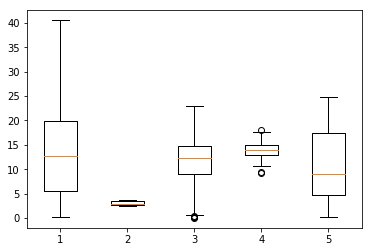

In [522]:
temps = {}
for study_id in set(mapping.study_id):
    print(study_id)
    temps[study_id] = mapping.loc[mapping.study_id == study_id, "temperature_deg_c"]
plt.boxplot([temps[i] for i in temps.keys()])

Feature Selection: Recursive Feature Selection vs. Biofiltered

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

In [20]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
test_size = 0.25
X_train, X_test, y_train, y_test, inx_train, inx_test = train_test_split(otu_norm, y, indicies, test_size = test_size, random_state = 0)


m = RandomForestRegressor(max_depth= 7, random_state=0, n_estimators= 1000)
m.fit(X_train, y_train)
#m = mutual_info_classif(X_train, y_train)



(3330, 11557)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [90]:
otu_norm.shape

(2536, 17000)

In [100]:
#Just esting something
features = SelectKBest(mutual_info_regression, k= 5).fit(X_test, y_test)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression


kf = KFold(n_splits = 3)
mses = list()
features_list = list()
for train_i, test_i in kf.split(otu_norm):
    X_train, X_test = otu_norm.iloc[train_i,:], otu_norm.iloc[test_i, :]
    y_train, y_test = map_train.iloc[train_i, :], map_train.iloc[test_i, :]
    y_train = y_train.temperature_deg_c
    y_test = y_test.temperature_deg_c
    
    print(X_train.shape)
    print(y_train.shape)
    k_obj = SelectKBest(mutual_info_regression, k= 10).fit(X_train, y_train)
    features = otu_norm.columns.values[k_obj.get_support()]
    
    
    print("features selected")
    m = svm.SVR(gamma = "scale")
    m.fit(X_train[features], y_train)
    print("Model fit")
    
    preds = m.predict(X_test[features])
    mse = np.mean([np.square(y_test[i] - preds[i]) for i in range(len(preds))])
    mses.append(mse)
    features_list.append(features)

    

(1723, 11132)
(1723,)
features selected
Model fit
(1723, 11132)
(1723,)
features selected
Model fit
(1724, 11132)
(1724,)


In [120]:
intersection = set(features_list[0])
for i in range(1, len(features_list)):
    intersection = intersection.intersection(set(features_list[i]))
    
intersection
file = open("ml_filtered_features.obj", "wb")
pickle.dump(intersection, file)
file.close()

In [23]:

print(m.feature_importances_)
np.max(m.feature_importances_)
np.sum(m.feature_importances_ > 0)
file = open('random_forest_train.obj', 'wb')
pickle.dump(m, file)
file.close()

[6.2530876e-06 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


In [56]:

ml_features = X_train.columns.values[m.feature_importances_ > 0]

def mlfilter(otu):
    #Filter for useful taxa
    otu_use = otu[list(ml_features)]
    return(otu_use)

X_train_ml = mlfilter(X_train)
X_test_ml= mlfilter(X_test)

In [5]:
f = open("feature_selection/ml_filtered_cv_mses.obj", "rb")
ml_mses = pickle.load(f)
f.close()

In [10]:
ml_mses
f = open("feature_selection/ml_filtered_features.obj", "rb")
ml_features = pickle.load(f)
f.close()
len(ml_features)

1573

In [35]:
#Feature selection using biofiltering
otu_biofilter_norm = biofilter(otu_norm)
print(otu_biofilter_norm.shape)
X_train_bio, X_test_bio, y_train, y_test, inx_train, inx_test = train_test_split(otu_biofilter_norm, y, indicies, test_size = test_size, random_state = 0)


(4441, 11557)


In [59]:
def randomfilter(otu):
    features = np.random.choice(otu.columns.values, otu_biofilter_norm.shape[1])
    otu_use = otu[list(features)]
    return(otu_use)

otu_norm_rand = randomfilter(otu_norm)
X_train_rand, X_test_rand, y_train, y_test, inx_train, inx_test = train_test_split(otu_norm_rand, y, indicies, test_size = test_size, random_state = 0)


In [43]:
from sklearn import preprocessing
X_train_ml_scaled = preprocessing.scale(X_train_ml)

27.58
Slope: 1.3556497109931327
R value: 0.655660579462326
Linear Error3.669151010849404   MSE: 21.69051526611634


(3.669151010849404, 21.69051526611634)

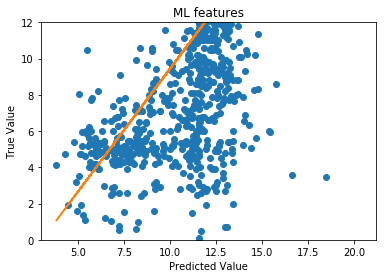

In [44]:

testModel(preprocessing.scale(X_train_ml), y_train, preprocessing.scale(X_test_ml), y_test, model = "svm", title = "ML features")

27.58
Slope: 0.9756702030603982
R value: 0.64015240152275
Linear Error3.4789258290593   MSE: 21.35674297289886


(3.4789258290593, 21.35674297289886)

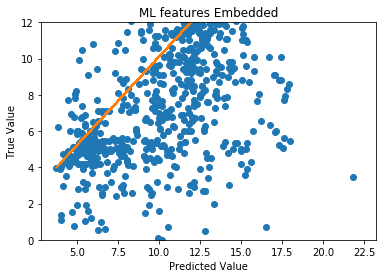

In [57]:
testModel(preprocessing.scale(embed(X_train_ml, qual_vecs_500)), y_train, preprocessing.scale(embed(X_test_ml, qual_vecs_500)), y_test, model = "svm", title = "ML features Embedded")

27.58
Slope: 1.4463804077189641
R value: 0.6408297508336329
Linear Error3.828835345221841   MSE: 22.741260139471148


(3.828835345221841, 22.741260139471148)

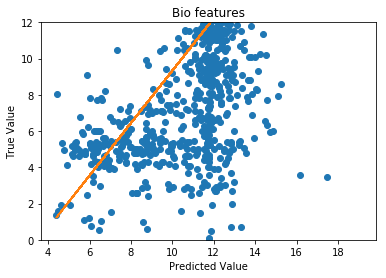

In [45]:
testModel(preprocessing.scale(X_train_bio), y_train, preprocessing.scale(X_test_bio), y_test, model = "svm", title = "Bio features")

27.58
Slope: 0.9756489130120843
R value: 0.6252055043971342
Linear Error3.5437759742882147   MSE: 22.03792771483834


(3.5437759742882147, 22.03792771483834)

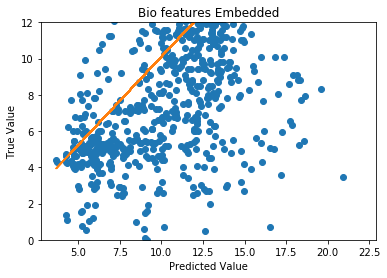

In [54]:
testModel(preprocessing.scale(embed(X_train_bio, qual_vecs_500)), y_train, 
          preprocessing.scale(embed(X_test_bio, qual_vecs_500)), y_test, model = "svm", title = "Bio features Embedded")

27.58
Slope: 1.4298161069773978
R value: 0.6376246454894146
Linear Error3.841267806969503   MSE: 22.79498008164086


(3.841267806969503, 22.79498008164086)

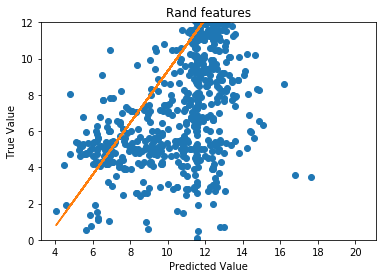

In [60]:
testModel(preprocessing.scale(X_train_rand), y_train, preprocessing.scale(X_test_rand), y_test, model = "svm", title = "Rand features")

27.58
Slope: 0.9988936174433366
R value: 0.5982012328565693
Linear Error3.72487667647753   MSE: 23.31606232322456


(3.72487667647753, 23.31606232322456)

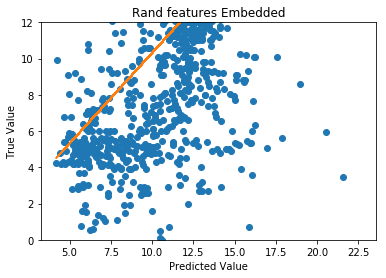

In [63]:
testModel(preprocessing.scale(embed(X_train_rand, qual_vecs_500)), y_train, preprocessing.scale(embed(X_test_rand, qual_vecs_500)), y_test, model = "svm", title = "Rand features Embedded")

In [74]:
#Are any of the features the same?
ml_features
file = open('taxa_lowphy_highcos.obj', 'rb')
taxa_lowphy_highcos = pickle.load(file)
file.close()
taxa_lowphy_highcos

ml_bio_feature_match = [ml_features[i] in taxa_lowphy_highcos for i in range(len(ml_features))]
print(str(np.sum(ml_bio_feature_match)) + " features match between ml and bio feature selection")

features_matched = ml_features[ml_bio_feature_match]

def matchedfilter(otu):
    otu_use = otu[list(features_matched)]
    return(otu_use)

X_train_match, X_test_match, y_train, y_test, inx_train, inx_test = train_test_split(matchedfilter(otu_norm), y, indicies, test_size = test_size, random_state = 0)


5499 features match between ml and bio feature selection


27.58
Slope: 1.3492856269130207
R value: 0.6550007979898109
Linear Error3.663913931641709   MSE: 21.69967801215286


(3.663913931641709, 21.69967801215286)

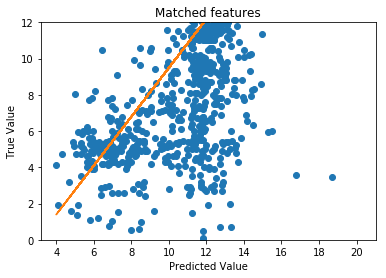

In [75]:
testModel(preprocessing.scale(X_train_match), y_train, preprocessing.scale(X_test_match), y_test, model = "svm", title = "Matched features")

27.58
Slope: 0.9763620110449219
R value: 0.6292572877137098
Linear Error3.5280598916784784   MSE: 21.850060775715157


(3.5280598916784784, 21.850060775715157)

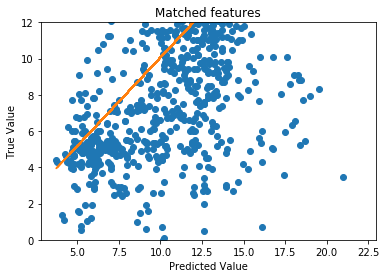

In [76]:
testModel(preprocessing.scale(embed(X_train_match, qual_vecs_500)), y_train, preprocessing.scale(embed(X_test_match, qual_vecs_500)), y_test, model = "svm", title = "Matched features Embedded")

ImportError: No module named 'skbio'

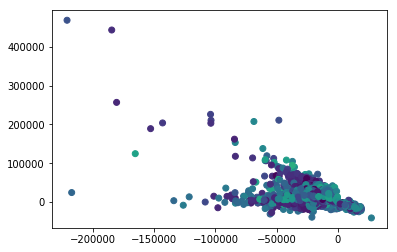

In [399]:
pd_otu_emb.add(map_temp.study_id)
i = 1
j = 2
plt.scatter(pd_otu_emb.iloc[:, i], pd_otu_emb.iloc[:, j], c = map_temp.temperature_deg_c, cmap='viridis')

#Permanova to see within/between study effects
#from skbio.stats.distance import permanova

dists_otu = pairwise_distances(otu_use, metric="cosine")
dists_emb = pairwise_distances(pd_otu_emb, metric = "cosine")

pm_otu = permanova(dists_otu, map_temp.study_id)
pm_emb = permanova(dists_emb, map_temp.study_id)

We'd like to test the difference in performance when using biologically informed feature selection as opposed to mathematically informed, such as PCA, as opposed to no selection, as opposed to random selection

In [375]:
#Should have all taxa included
otu_use = otu_t
print(otu_use.shape)


#Select using bio-informed
file = open('taxa_lowphy_highcos.obj', 'rb')
taxa_lowphy_highcos = list(pickle.load(file))
otu_use = otu_norm[taxa_lowphy_highcos]
print(otu_use.shape)
X_train_bioselect, X_test_bioselect, y_train, y_test, inx_train, inx_test = train_test_split(otu_use, y, indicies, test_size = test_size, random_state = 0)


(4490, 17000)
(4490, 11557)


27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 1.2094951046097224
R value: 0.38825908538828746
Linear Error4.5534124015670345   MSE: 30.729984751984727


KeyboardInterrupt: 

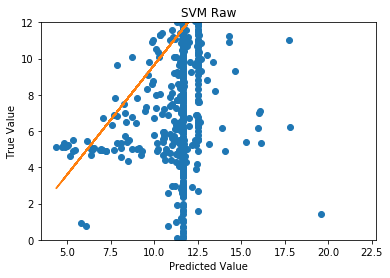

In [376]:
testModel(X_train_bioselect, y_train, X_test_bioselect, y_test, model = "svm", title = "SVM Bioselect Norm")
testModel(X_train_bioselect, y_train, X_test_bioselect, y_test, model = "rf", title = "RF Bioselect Norm")

In [ ]:
otu_use = otu_t[taxa_lowphy_highcos]
X_train_bioselect_nonorm, X_test_bioselect_nonorm, y_train, y_test, inx_train, inx_test = train_test_split(otu_use, y, indicies, test_size = test_size, random_state = 0)

testModel(X_train_bioselect_nonorm, y_train, X_test_bioselect_nonorm, y_test, model = "svm", title = "SVM Bioselect No Norm")
testModel(X_train_bioselect_nonorm, y_train, X_test_bioselect_nonorm, y_test, model = "rf", title = "RF Bioselect No Norm")

In [ ]:
otu_use = otu_t
X_train_nonorm, X_test_nonorm, y_train, y_test, inx_train, inx_test = train_test_split(otu_use, y, indicies, test_size = test_size, random_state = 0)
testModel(X_train_nonorm, y_train, X_test_nonorm, y_test, model = "svm", title = "SVM All No Norm")
testModel(X_train_nonorm, y_train, X_test_nonorm, y_test, model = "rf", title = "RF All No Norm")

In [ ]:
#Normalize
sample_sums = otu_t.sum(axis=1)
print(len(sample_sums))
otu_norm = otu_t.div(sample_sums, axis=0)
otu_use = otu_norm

X_train_norm, X_test_norm, y_train, y_test, inx_train, inx_test = train_test_split(otu_use, y, indicies, test_size = test_size, random_state = 0)
testModel(X_train_norm, y_train, X_test_norm, y_test, model = "svm", title = "SVM All Norm")
testModel(X_train_norm, y_train, X_test_norm, y_test, model = "rf", title = "RF All Norm")

27.2
(array([104, 380], dtype=int64),)
(array([776], dtype=int64),)
[104 380 776]
Slope: 0.2794908171851119
R value: 0.20507960020835708
Linear Error4.866222512377679   MSE: 44.53715320309173


(4.866222512377679, 44.53715320309173)

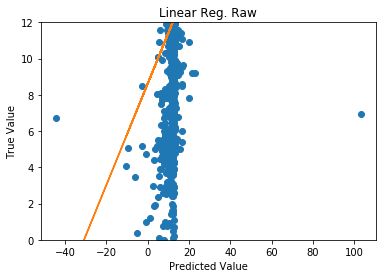

In [371]:
testModel(X_train_bioselect, y_train, X_test_bioselect, y_test, model = "linreg", title = "Linear Reg. Raw")

27.2
(array([104, 380], dtype=int64),)
(array([776], dtype=int64),)
[104 380 776]
Slope: 0.17487430209923605
R value: 0.13077346317646965
Linear Error4.934505712951627   MSE: 49.078919654821675


(4.934505712951627, 49.078919654821675)

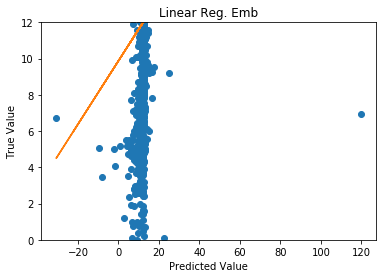

In [363]:
testModel(X_train_emb, y_train, X_test_emb, y_test, model = "linreg", title = "Linear Reg. Emb")

27.2
(array([380], dtype=int64),)
(array([776], dtype=int64),)
[380 776]
Slope: 0.24887743645524008
R value: 0.16609303635989706
Linear Error4.838721362386812   MSE: 44.04200045322573


(4.838721362386812, 44.04200045322573)

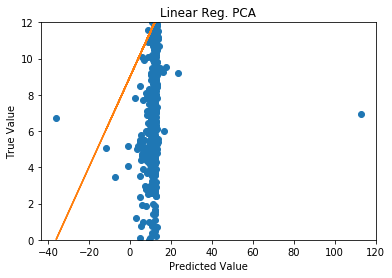

In [365]:
testModel(X_train_pca, y_train, X_test_pca, y_test, model = "linreg", title = "Linear Reg. PCA")

In [64]:
pca.

<bound method PCA.fit of PCA(copy=True, iterated_power='auto', n_components=500, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)>

In [69]:
train = np.matmul(X_train, pca.components_.T)
print(train.shape)
print(X_train_pca.shape)
print(train[0,][0:10])
print(X_train_pca[0,][0:10])
file_pca_comp = open("pca_components.obj", "wb")
pickle.dump(pca.components_.T, file_pca_comp)

(3367, 500)
(3367, 500)
[ 0.11922328  0.08686681 -0.01786226  0.01268317 -0.03566762  0.01573331
  0.04906855  0.01760109  0.01060006 -0.0685633 ]
[ 0.07289871  0.0780319  -0.02031232  0.00174199 -0.01874056  0.00373193
  0.02158674  0.00577211  0.00608026 -0.06438877]


In [71]:

file_taxa = open("taxa.obj", "wb")
pickle.dump(otu_t.columns.values, file_taxa)

In [37]:
print(np.dot(otu_t.iloc[0,], pca.components_[0,]))
print(X_train.iloc[0,0])

-2024.852199764971
1.1110864203017711e-05


In [ ]:
pca_train_file = open("pca_train.obj", "wb")
pickle.dump(pca_train_file, X_train_pca)

In [140]:
otu_file = open("otu_train.obj", "wb")
pickle.dump(otu_t.iloc[inx_train, :], otu_file)

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 0.7788410872994377
R value: 0.3566221040804578
Linear Error4.497885847463234   MSE: 32.04120688349182


(4.497885847463234, 32.04120688349182)

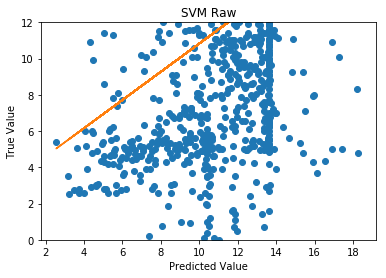

In [339]:
testModel(X_train, y_train, X_test, y_test, model = "svm", title = "SVM Raw")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 0.9235878810188003
R value: 0.37669480879269723
Linear Error4.5214239657138675   MSE: 31.17583598128151


(4.5214239657138675, 31.17583598128151)

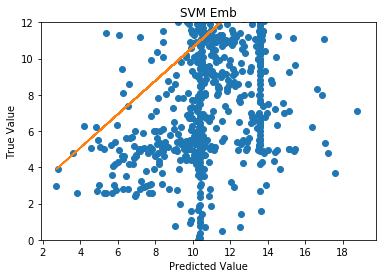

In [340]:
testModel(X_train_emb, y_train, X_test_emb, y_test, model = "svm", title = "SVM Emb")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 0.7957515467542705
R value: 0.36122324677152856
Linear Error4.489812802001203   MSE: 31.860364956921565


(4.489812802001203, 31.860364956921565)

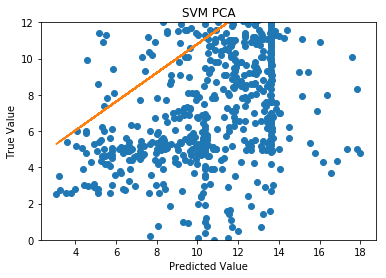

In [341]:
testModel(X_train_pca, y_train, X_test_pca, y_test, model = "svm", title = "SVM PCA")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 0.9836262870840385
R value: 0.5523690356507021
Linear Error3.8641281348580465   MSE: 25.052342628531505


(3.8641281348580465, 25.052342628531505)

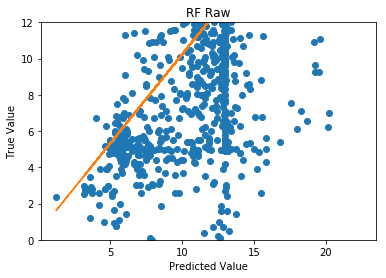

In [342]:
testModel(X_train, y_train, X_test, y_test, model = "rf", title = "RF Raw")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 0.9825833520728866
R value: 0.5024738752104487
Linear Error4.090740752359529   MSE: 26.941126610812127


(4.090740752359529, 26.941126610812127)

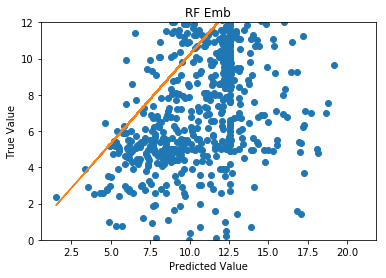

In [343]:
testModel(X_train_emb, y_train, X_test_emb, y_test, model = "rf", title = "RF Emb")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 1.0687555901512964
R value: 0.5467970194557351
Linear Error3.951320369824332   MSE: 25.30034247621333


(3.951320369824332, 25.30034247621333)

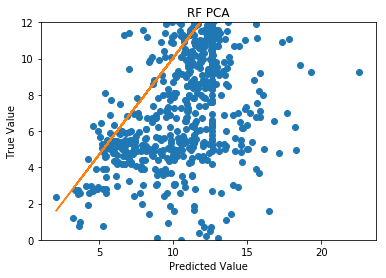

In [344]:
testModel(X_train_pca, y_train, X_test_pca, y_test, model = "rf", title = "RF PCA")

Try Unfeature selected data

In [350]:
#Normalize
sample_sums = otu_t.sum(axis=1)
print(len(sample_sums))
otu_norm = otu_t.div(sample_sums, axis=0)
otu_norm = otu_t

otu_use = otu_norm
print(otu_use.shape)
otu_emb_100 = np.dot(otu_use, qual_vecs)
print(otu_emb_100.shape)

4490
(4490, 17000)
(4490, 100)


In [349]:
test_size = 0.25
X_train, X_test, y_train, y_test, inx_train, inx_test = train_test_split(otu_use, y, indicies, test_size = test_size, random_state = 0)

X_train_emb, X_test_emb, y_train, y_test = train_test_split(otu_emb_100, y, test_size = test_size, random_state = 0)
#Splits are the same b/c of same random state

pca = PCA(n_components= 100)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

map_train = map_temp.iloc[inx_train, :]

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 1.1024630120443557
R value: 0.6956501424520114
Linear Error3.2462387343309866   MSE: 18.75465476428059


(3.2462387343309866, 18.75465476428059)

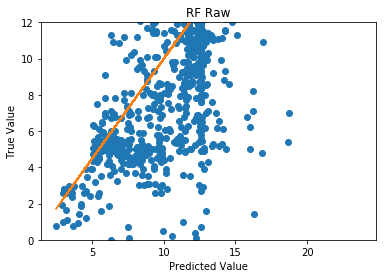

In [351]:
testModel(X_train, y_train, X_test, y_test, model = "rf", title = "RF Raw")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 1.0808392532427629
R value: 0.6325033453958048
Linear Error3.560337054017148   MSE: 21.67441564039132


(3.560337054017148, 21.67441564039132)

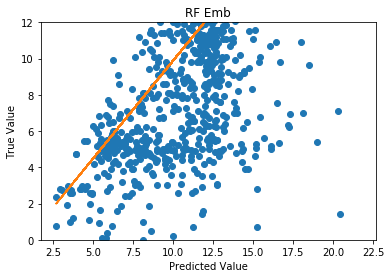

In [352]:
testModel(X_train_emb, y_train, X_test_emb, y_test, model = "rf", title = "RF Emb")

27.2
(array([], dtype=int64),)
(array([], dtype=int64),)
[]
Slope: 1.061715911261232
R value: 0.6598363537905041
Linear Error3.381125532185993   MSE: 20.374273493476906


(3.381125532185993, 20.374273493476906)

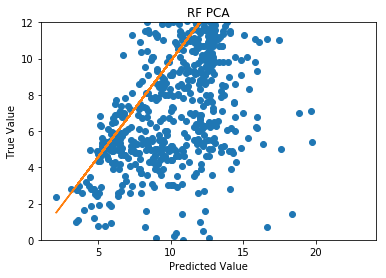

In [353]:
testModel(X_train_pca, y_train, X_test_pca, y_test, model = "rf", title = "RF PCA")

In [204]:
def tuneRF(n_est, max_depth):
    rf_emb = RandomForestRegressor(max_depth= max_depth, random_state=0, n_estimators=n_est)
    rf_emb.fit(X_train_emb, y_train)
    scores = cross_val_score(rf_emb, X_train_emb, y_train, cv=5)
    
    #preds_emb_rf = rf_emb.predict(X_test_emb)
    #preds_emb_rf_train = rf_emb.predict(X_train_emb)
    #test_err = mean_squared_error(y_test, preds_emb_rf)
    #train_err = mean_squared_error(y_train, preds_emb_rf_train)
    return(rf_emb, scores.mean())

In [205]:
#n_estimators = [80, 100, 120, 140]
#max_depths = [8, 10, 12, 14]
#scores = []
#for n_est in n_estimators:
#    for max_depth in max_depths:
#        print(str(n_est) + "  " + str(max_depth))
#        rf_emb, score_mean = tuneRF(n_est, max_depth)
#        scores.append(score_mean)

In [206]:
#print(scores[0:4])
#print(scores[4:8])
#print(scores[8:12])
#print(scores[12:16])

In [42]:
#phosphate_umol_per_l
map_filt_sort.columns.values

array(['BarcodeSequence', 'LinkerPrimerSequence', 'Description',
       'host_subject_id', 'study_id', 'title', 'principal_investigator',
       'doi', 'ebi_accession', 'target_gene', 'target_subfragment',
       'pcr_primers', 'illumina_technology', 'extraction_center',
       'run_center', 'run_date', 'read_length_bp',
       'sequences_split_libraries', 'observations_closed_ref_greengenes',
       'observations_closed_ref_silva',
       'observations_open_ref_greengenes', 'observations_deblur_90bp',
       'observations_deblur_100bp', 'observations_deblur_150bp',
       'emp_release1', 'qc_filtered', 'subset_10k', 'subset_5k',
       'subset_2k', 'sample_taxid', 'sample_scientific_name',
       'host_taxid', 'host_common_name_provided', 'host_common_name',
       'host_scientific_name', 'host_superkingdom', 'host_kingdom',
       'host_phylum', 'host_class', 'host_order', 'host_family',
       'host_genus', 'host_species', 'collection_timestamp', 'country',
       'latitude_deg', 'l

In [49]:
#phosphate
#ammonia
criteria = 'ph'
bools =  ~map_filt_sort[criteria].isnull() 
map_temp = map_filt_sort.loc[~map_filt_sort[criteria].isnull()]
otu_temp = otu_sort.loc[:, bools]
bools_correct = [map_temp.index.values[i] == otu_temp.columns.values[i] for i in range(map_temp.shape[0])]
print("We will be working with " + str(np.sum(bools_correct)) + " samples that have temperature information")

We will be working with 3031 samples that have temperature information


In [50]:
#One final check after all transformations
qual_vecs = qual_vecs_sort
bools_correct = [qual_vecs.index.values[i] == otu_temp.index.values[i] for i in range(ntaxa)]
if (np.sum(bools_correct) == qual_vecs_sort.shape[0]) and (np.sum(bools_correct) == otu.shape[0]):
    print("Safe to continue")
else:
    print("STOP! Something is wrong.")

Safe to continue


In [51]:
otu_t = otu_temp.transpose()
otu_emb_100 = np.dot(otu_t, qual_vecs)
print(otu_emb_100.shape)

(3031, 500)


In [53]:
y = map_temp[criteria]
X_train, X_test, y_train, y_test = train_test_split(otu_t, y, test_size = 0.25, random_state = 0)


In [54]:
X_train_emb, X_test_emb, y_train, y_test = train_test_split(otu_emb_100, y, test_size = 0.25, random_state = 0)
#Splits are the same b/c of same random state

In [55]:
components = X_train_emb.shape[1]
pca = PCA(n_components=components)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [103]:
null_dist = []
for j in range(5000):
    select_taxa = np.random.choice([i for i in range(X_train.shape[1])], components)
    #print(len(select_taxa))
    X_train_rand = X_train.iloc[:, select_taxa]
    X_test_rand = X_test.iloc[:, select_taxa]
    err = testModel(X_train_rand, y_train, X_test_rand, y_test, model = "linreg", title = "Linear Reg. Rand")
    null_dist.append(err)
    if j % 100 == 0:
        print(j)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [112]:
np.sum([i <= 0.6172226389183603 for i in null_dist])
# waaaay better than just picking random variables. 

0

246362223.15073216
Slope: 480.6602729135392
R value: 0.02964792657204367


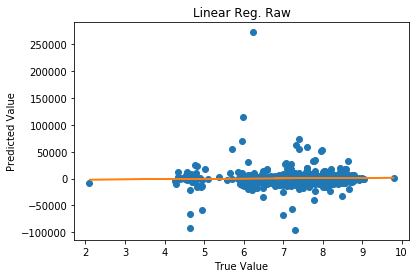

In [56]:
testModel(X_train, y_train, X_test, y_test, model = "linreg", title = "Linear Reg. Raw")

0.6172226389183603
Slope: 0.48300495629525275
R value: 0.45594972978440623


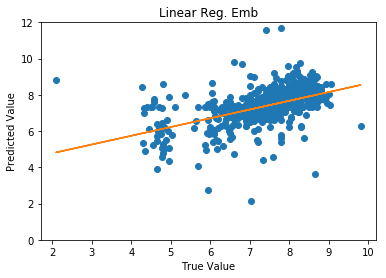

In [74]:
testModel(X_train_emb, y_train, X_test_emb, y_test, model = "linreg", title = "Linear Reg. Emb")

0.5261415555518236
Slope: 0.4997419464503838
R value: 0.6076986480079947


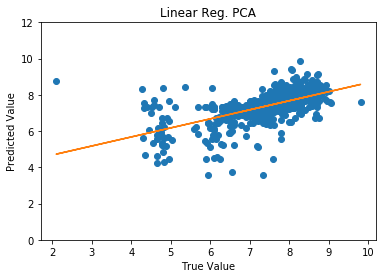

In [75]:
testModel(X_train_pca, y_train, X_test_pca, y_test, model = "linreg", title = "Linear Reg. PCA")